In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle
import time
import sys

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


2022-05-17 19:32:24.819315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-17 19:32:24.819338: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

2022-05-17 19:32:26.273663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 19:32:26.307215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-17 19:32:26.307359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-17 19:32:26.307452: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared obj

# Ennio Doorbell Data Pre-Processing

In [3]:
# Benign traffic

ed_benign = pd.read_csv('nbaiot/Ennio_Doorbell/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_ed_benign = ed_benign.copy(deep=True)

columns = list(df_ed_benign.columns)
chosen_columns = []
for column in columns:
    if column.find('L5') != -1:
        chosen_columns.append(column)
        
df_ed_benign = pd.DataFrame(df_ed_benign, columns = chosen_columns)

# Bashlite

ed_bashlite_combo = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_combo = ed_bashlite_combo.copy(deep=True)
df_ed_bashlite_combo = pd.DataFrame(df_ed_bashlite_combo, columns = chosen_columns)

ed_bashlite_junk = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_junk = ed_bashlite_junk.copy(deep=True)
df_ed_bashlite_junk = pd.DataFrame(df_ed_bashlite_junk, columns = chosen_columns)

ed_bashlite_scan = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_scan = ed_bashlite_scan.copy(deep=True)
df_ed_bashlite_scan = pd.DataFrame(df_ed_bashlite_scan, columns = chosen_columns)

ed_bashlite_udp = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_udp = ed_bashlite_udp.copy(deep=True)
df_ed_bashlite_udp = pd.DataFrame(df_ed_bashlite_udp, columns = chosen_columns)

ed_bashlite_tcp = pd.read_csv('nbaiot/Ennio_Doorbell/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_tcp = ed_bashlite_tcp.copy(deep=True)
df_ed_bashlite_tcp = pd.DataFrame(df_ed_bashlite_tcp, columns = chosen_columns)

In [4]:
scaler = MinMaxScaler()
df_ed_benign_norm = scaler.fit_transform(df_ed_benign)

df_ed_bashlitecombo_norm = scaler.fit_transform(df_ed_bashlite_combo)
df_ed_bashlitejunk_norm = scaler.fit_transform(df_ed_bashlite_junk)
df_ed_bashlitescan_norm = scaler.fit_transform(df_ed_bashlite_scan)
df_ed_bashliteudp_norm = scaler.fit_transform(df_ed_bashlite_udp)
df_ed_bashlitetcp_norm = scaler.fit_transform(df_ed_bashlite_tcp)

# Variational Autoencoder - Attack Detection

## Model

In [5]:
# Train set

len_benign = len(df_ed_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_ed_benign_norm[:len_benign_train]

# Test set - 30% benign and the rest is attack

X_test_benign = df_ed_benign_norm[len_benign_train:]

len_attack_test = len(X_test_benign)
X_test_bashlite_combo = df_ed_bashlitecombo_norm
X_test_bashlite_junk = df_ed_bashlitejunk_norm
X_test_bashlite_scan = df_ed_bashlitescan_norm
X_test_bashlite_tcp = df_ed_bashlitetcp_norm
X_test_bashlite_udp = df_ed_bashliteudp_norm

X_test_VAE = np.concatenate([X_test_benign, X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan,
                             X_test_bashlite_tcp, X_test_bashlite_udp])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0

In [6]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [7]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 350
learning_rate = 0.0001
batch_size = 22
anomaly_threshold = 0.05
number_features = 23

In [8]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 23)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 11)           264         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 7)            84          ['dense[0][0]']                  
                                                                                                  
 z_var (Dense)                  (None, 7)            84          ['dense[0][0]']                  
                                                                                            

In [9]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 7)]               0         
                                                                 
 dense_1 (Dense)             (None, 11)                88        
                                                                 
 dense_2 (Dense)             (None, 23)                276       
                                                                 
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [10]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 23)]              0         
                                                                 
 encoder (Functional)        (None, 7)                 432       
                                                                 
 decoder (Functional)        (None, 23)                364       
                                                                 
Total params: 796
Trainable params: 796
Non-trainable params: 0
_________________________________________________________________


## Train

In [11]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)

train_end = time.time()
train_time = train_end - train_start
print("Training time:", train_time)

Train on 27370 samples
Epoch 1/350


2022-05-17 19:32:31.840511: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-17 19:32:31.859631: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


27370/27370 [==============================] - 2s 66us/sample - loss: 74.7372
Epoch 2/350
27370/27370 [==============================] - 2s 57us/sample - loss: 15.8603
Epoch 3/350
27370/27370 [==============================] - 2s 58us/sample - loss: 6.8937
Epoch 4/350
27370/27370 [==============================] - 2s 62us/sample - loss: 5.1758
Epoch 5/350
27370/27370 [==============================] - 1s 54us/sample - loss: 4.0524
Epoch 6/350
27370/27370 [==============================] - 1s 53us/sample - loss: 3.4161
Epoch 7/350
27370/27370 [==============================] - 2s 58us/sample - loss: 2.9781
Epoch 8/350
27370/27370 [==============================] - 2s 58us/sample - loss: 2.5810
Epoch 9/350
27370/27370 [==============================] - 1s 49us/sample - loss: 2.2543
Epoch 10/350
27370/27370 [==============================] - 1s 47us/sample - loss: 2.0341
Epoch 11/350
27370/27370 [==============================] - 1s 46us/sample - loss: 1.8600
Epoch 12/350
27370/27370 [===

27370/27370 [==============================] - 1s 50us/sample - loss: 1.1815
Epoch 93/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.2018
Epoch 94/350
27370/27370 [==============================] - 1s 48us/sample - loss: 1.2114
Epoch 95/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.1987
Epoch 96/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.1923
Epoch 97/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.2056
Epoch 98/350
27370/27370 [==============================] - 1s 48us/sample - loss: 1.1980
Epoch 99/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.2136
Epoch 100/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.2226
Epoch 101/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.2162
Epoch 102/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.2206
Epoch 103/350
27370/

27370/27370 [==============================] - 1s 49us/sample - loss: 1.0342
Epoch 183/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.0444
Epoch 184/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.0504
Epoch 185/350
27370/27370 [==============================] - 1s 49us/sample - loss: 1.0348
Epoch 186/350
27370/27370 [==============================] - 1s 49us/sample - loss: 1.0275
Epoch 187/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.0281
Epoch 188/350
27370/27370 [==============================] - 1s 49us/sample - loss: 1.0254
Epoch 189/350
27370/27370 [==============================] - 1s 51us/sample - loss: 1.0284
Epoch 190/350
27370/27370 [==============================] - 1s 49us/sample - loss: 1.0183
Epoch 191/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.0298
Epoch 192/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.0296
Epoch 193/350

27370/27370 [==============================] - 1s 48us/sample - loss: 1.0218
Epoch 273/350
27370/27370 [==============================] - 1s 49us/sample - loss: 1.0402
Epoch 274/350
27370/27370 [==============================] - 1s 49us/sample - loss: 1.0191
Epoch 275/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.0225
Epoch 276/350
27370/27370 [==============================] - 1s 49us/sample - loss: 1.0276
Epoch 277/350
27370/27370 [==============================] - 1s 50us/sample - loss: 1.0246
Epoch 278/350
27370/27370 [==============================] - 1s 49us/sample - loss: 1.0210
Epoch 279/350
27370/27370 [==============================] - 1s 51us/sample - loss: 1.0157
Epoch 280/350
27370/27370 [==============================] - 1s 49us/sample - loss: 1.0264
Epoch 281/350
27370/27370 [==============================] - 1s 49us/sample - loss: 1.0384
Epoch 282/350
27370/27370 [==============================] - 1s 49us/sample - loss: 1.0391
Epoch 283/350

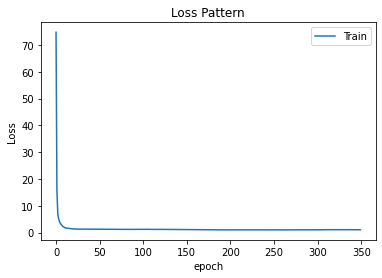

In [12]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [13]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = VariationalAutoencoderModel.get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold
# np.quantile(error_vector, anomaly_threshold)

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

/home/andressa.amaral/.local/lib/python3.7/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [14]:
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time:", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = VariationalAutoencoderModel.get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

Testing time: 5.562482118606567
[False False False ...  True  True  True]


0.9123000030475726

In [15]:
print(len(X_test_VAE))

328130


## Metrics

In [16]:
CM = confusion_matrix(Y_test_VAE, attacks)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

FPR = FP/(FP+TN)

In [17]:
sys.stdout = open("Results/ennio_doorbell.txt", "a")

print(" ==== Test " + str(number_features) + " Normal learning rate and anomaly threshold ====")
print("Training time:" + str(train_time))
print("Testing time:" + str(test_time))
print(classification_report(Y_test_VAE, attacks, digits = 5))
print("TN:" + str(TN) + " FN:" + str(FN) + " TP:" + str(TP) + " FP:" +  str(FP) + "FPR:" +  str(FPR))

In [18]:
'''# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)'''

'# Examinig the latent space generated by the encoder\n\nX_encoded = encoder.predict(X_test_VAE)\n\npca = PCA(n_components=2)\nX_analysis = pca.fit_transform(X_encoded)'

In [19]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)\nplt.grid()\nplt.show()\n\n# Darker clusters indicate that the error is higher'

In [20]:
'''plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies'''

'plt.figure(figsize=(12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)\nplt.grid()\nplt.show()\n\n# Orange ones are anomalies'

In [21]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)
plt.grid()
plt.show()

# Ground truth'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)\nplt.grid()\nplt.show()\n\n# Ground truth'